# A Quantum-Enhanced LSTM Layer

One field that so far has been poorly explored in Quantum Machine Learning is Natural Language Processing (NLP), the sub-field of Artificial Intelligence that gives computers the ability to read, write and to some extent comprehend written text. 

As documents are usually presented as sequences of words, historically one of the most successful techniques to manipulate this kind of data has been the Recurrent Neural Network architecture, and in particular a variant called Long Short-Term Memory (LSTM). LSTMs allowed machines to perform translations, classification and intent detection with state-of-the-art accuracy until the advent of Transformer networks. Still, it’s interesting at least from an educational point of view to dig into LSTMs to see what good quantum computing may bring to the field. For a more thorough discussion, please refer to “Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783) and “Recurrent Quantum Neural Networks” by J. Bausch (arXiv:2006.14619).

In [1]:
# !pip install -r requirements.txt

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qlstm_pennylane import QLSTM

c:\Users\cpb5867\Anaconda3\envs\QLSTM\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Here we define the possible tags: determinant, noun, verb.

In [3]:
# tag_to_ix = {"<RX_1>": 0, "<RX_2>": 1, "<RX_3>": 2, "<RX_4>": 3, "<RX_5>": 4, "<RX_6>": 5, "<RX_7>": 6, "<RX_8>": 7, "<RX_9>": 8, "<RX_10>": 9 }  # Assign each tag with a unique index
# ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [4]:
def prepare_sequence(seq, to_ix):
    # idxs = [to_ix[w] for w in seq]
    idxs = [to_ix[seq]]
    return torch.tensor(idxs, dtype=torch.long)

In [5]:
goal_reaction_type = '<RX_1>'
reactions = []
smiles = open('USPTO-50K/src-train.txt', 'r')
content = smiles.read()
smile_strings = content.split('\n')
smile_strings.remove('')

reactants = []
smiles2 = open('USPTO-50K/tgt-train.txt', 'r')
content2 = smiles2.read()
smile_strings2 = content2.split('\n')
smile_strings2.remove('')

for idx in range(len(smile_strings)):
    reaction_type = smile_strings[idx].replace(" ", "").split('>',1)[0] + '>'
    if reaction_type != None and goal_reaction_type in reaction_type:
        reactions.append(smile_strings[idx].replace(" ", "").split('>',1)[1])
        reactants.append(smile_strings2[idx].replace(" ", ""))
    smile_strings[idx] = smile_strings[idx].replace(" ", "").split('>',1)[1]
    
smiles.close()
smiles2.close()

# print(len(reactions))

tag_to_ix = {}
for reactant in reactants:
    if reactant not in tag_to_ix:  # word has not been assigned an index yet
        tag_to_ix[reactant] = len(tag_to_ix)  # Assign each word with a unique index


# tag_to_ix = {"<RX_1>": 0, "<RX_2>": 1, "<RX_3>": 2, "<RX_4>": 3, "<RX_5>": 4, "<RX_6>": 5, "<RX_7>": 6, "<RX_8>": 7, "<RX_9>": 8, "<RX_10>": 9 }  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

# print(tmp_arr)
# print(tag_to_ix[-3:])
# print(ix_to_tag[-3:])

Now we can prepare the input dataset.

In [6]:
# training_data = [
#     # Tags are: DET - determiner; NN - noun; V - verb
#     # For example, the word "The" is a determiner
#     ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
#     ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
# ]
training_data = list(zip(reactions, reactants))

training_data = training_data[-5:]
print(training_data)

word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    if sent not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[sent] = len(word_to_ix)  # Assign each word with a unique index

# print(f"Vocabulary: {word_to_ix}")
# print(f"Entities: {ix_to_tag}")

[('COc1ccc(N(C)c2nc(N(C)C)nc3ccc([N+](=O)[O-])cc23)cc1', 'CNC.COc1ccc(N(C)c2nc(Cl)nc3ccc([N+](=O)[O-])cc23)cc1'), ('COc1cc2c(cc1OC)[C@@H](CN(C)CCCNCC(OC)OC)C2', 'COC(C=O)OC.COc1cc2c(cc1OC)[C@@H](CN(C)CCCN)C2'), ('CCCn1cc(CC)nc1-c1cnc(Nc2ccc(Cl)cc2)c(Cl)c1', 'CCCI.CCc1c[nH]c(-c2cnc(Nc3ccc(Cl)cc3)c(Cl)c2)n1'), ('COC(=O)c1ncc(NS(=O)(=O)c2ccncc2)cc1F', 'COC(=O)c1ncc(Br)cc1F.NS(=O)(=O)c1ccncc1'), ('Cc1nc2ccccc2n1-c1nc(N2CCOCC2)c2nc(CN3CCC(C#N)CC3)n(C)c2n1', 'Cc1nc2ccccc2n1-c1nc(N2CCOCC2)c2nc(CBr)n(C)c2n1.N#CC1CCNCC1')]


The idea is to pass the two sequences through the LSTM, which will output the hidden array of vectors [h_0, h_1, h_2, h_3, h_4], one for each word. A dense layer “head” is attached to the LSTM’s outputs to calculate the probability that each word may be a determinant, noun or verb.

In [7]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        # print(sentence)
        embeds = self.word_embeddings(sentence)
        # lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out, _ = self.lstm(embeds.view(1, 1, -1))
        # tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_logits = self.hidden2tag(lstm_out.view(1, -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [8]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 300

In [9]:
model_classical = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs. 

In [10]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            # print("Scores")
            # print(tag_scores)
            # print("Labels")
            # print(labels)
            
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))
            
            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)
        
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [11]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 300: Loss = 9.344 Acc = 0.00
Epoch 2 / 300: Loss = 9.216 Acc = 0.00
Epoch 3 / 300: Loss = 9.089 Acc = 0.40
Epoch 4 / 300: Loss = 8.960 Acc = 0.40
Epoch 5 / 300: Loss = 8.831 Acc = 0.40
Epoch 6 / 300: Loss = 8.700 Acc = 0.40
Epoch 7 / 300: Loss = 8.567 Acc = 0.40
Epoch 8 / 300: Loss = 8.431 Acc = 0.40
Epoch 9 / 300: Loss = 8.291 Acc = 0.40
Epoch 10 / 300: Loss = 8.147 Acc = 0.40
Epoch 11 / 300: Loss = 7.999 Acc = 0.40
Epoch 12 / 300: Loss = 7.846 Acc = 0.40
Epoch 13 / 300: Loss = 7.687 Acc = 0.60
Epoch 14 / 300: Loss = 7.523 Acc = 0.60
Epoch 15 / 300: Loss = 7.352 Acc = 0.80
Epoch 16 / 300: Loss = 7.174 Acc = 0.80
Epoch 17 / 300: Loss = 6.990 Acc = 0.80
Epoch 18 / 300: Loss = 6.798 Acc = 0.80
Epoch 19 / 300: Loss = 6.598 Acc = 0.80
Epoch 20 / 300: Loss = 6.389 Acc = 0.80
Epoch 21 / 300: Loss = 6.173 Acc = 0.80
Epoch 22 / 300: Loss = 5.947 Acc = 0.80
Epoch 23 / 300: Loss = 5.713 Acc = 0.80
Epoch 24 / 300: Loss = 5.470 Acc = 0.80
Epoch 25 / 300: Loss = 5.218 Acc = 0.80
Epoch 26 

In [12]:
def print_result(model):
    with torch.no_grad():
        input_sentence = training_data[0][0]
        labels = training_data[0][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [13]:
print_result(model_classical)

Sentence:  COc1ccc(N(C)c2nc(N(C)C)nc3ccc([N+](=O)[O-])cc23)cc1
Labels:    CNC.COc1ccc(N(C)c2nc(Cl)nc3ccc([N+](=O)[O-])cc23)cc1
Predicted: ['CNC.COc1ccc(N(C)c2nc(Cl)nc3ccc([N+](=O)[O-])cc23)cc1']


In [14]:
# print(reactions[0])
# print(smile_strings[0])

In [15]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim, 
                        hidden_dim, 
                        vocab_size=len(word_to_ix), 
                        tagset_size=len(tag_to_ix), 
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [16]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 300: Loss = 9.274 Acc = 0.00
Epoch 2 / 300: Loss = 9.167 Acc = 0.20
Epoch 3 / 300: Loss = 9.059 Acc = 0.20
Epoch 4 / 300: Loss = 8.950 Acc = 0.20
Epoch 5 / 300: Loss = 8.840 Acc = 0.20
Epoch 6 / 300: Loss = 8.729 Acc = 0.20
Epoch 7 / 300: Loss = 8.616 Acc = 0.20
Epoch 8 / 300: Loss = 8.502 Acc = 0.20
Epoch 9 / 300: Loss = 8.385 Acc = 0.20
Epoch 10 / 300: Loss = 8.267 Acc = 0.20
Epoch 11 / 300: Loss = 8.145 Acc = 0.00
Epoch 12 / 300: Loss = 8.022 Acc = 0.00
Epoch 13 / 300: Loss = 7.895 Acc = 0.00
Epoch 14 / 300: Loss = 7.765 Acc = 0.00
Epoch 15 / 300: Loss = 7.633 Acc = 0.00
Epoch 16 / 300: Loss = 7.497 Acc = 0.00
Epoch 17 / 300: Loss = 7.358 Acc = 0.00
Epoch 18 / 300: Loss = 7.215 Acc = 0.20
Epoch 19 / 300: Loss = 7.070 Acc = 0.20
Epoch 20 / 300: Loss = 6.921 Acc = 0.20
Epoch 21 / 300: Loss = 6.769 Acc = 0.20
Epoch 22 / 300: Loss = 6.615 Acc = 0.20
Epoch 23 / 300: Loss = 6.459 Acc = 0.20
Epoch 24 / 300: Loss = 6.300 Acc = 0.20
Epoch 25 / 300: Loss = 6.139 Acc = 0.20
Epoch 26 

In [17]:
print_result(model_quantum)

Sentence:  COc1ccc(N(C)c2nc(N(C)C)nc3ccc([N+](=O)[O-])cc23)cc1
Labels:    CNC.COc1ccc(N(C)c2nc(Cl)nc3ccc([N+](=O)[O-])cc23)cc1
Predicted: ['CNC.COc1ccc(N(C)c2nc(Cl)nc3ccc([N+](=O)[O-])cc23)cc1']


### Plot the training history

In [18]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper right", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

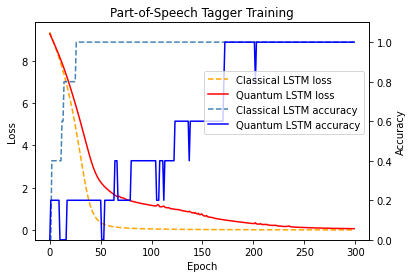

In [19]:
plot_history(history_classical, history_quantum)

The loss function decreases as a function of the training epoch, and after 300 epochs both networks are able to tag correctly the first sentence. Due to the complexity of the simulation of the quantum circuit, it took approximatively 15 minutes to finish the training, to be compared to a mere 8 seconds for the classical case. 